In [2]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
togo_df = pd.read_csv('../data/togo-dapaong_qc.csv')
print("Togo dataset loaded successfully!")
print(f"Shape: {togo_df.shape}")

Togo dataset loaded successfully!
Shape: (525600, 19)


In [3]:
# Cell 2: Summary Statistics & Missing-Value Report
print("=== 1. SUMMARY STATISTICS & MISSING-VALUE REPORT ===")

# Basic info
print("\nDataset Info:")
print(togo_df.info())

# Summary statistics
print("\nSummary Statistics:")
numeric_cols = togo_df.select_dtypes(include=[np.number]).columns
print(togo_df[numeric_cols].describe())

# Missing value analysis
missing_summary = togo_df.isnull().sum()
missing_percentage = (togo_df.isnull().sum() / len(togo_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing Percentage': missing_percentage
})
print("\nMissing Values Analysis:")
print(missing_df)

# Identify columns with >5% nulls
high_missing_cols = missing_df[missing_df['Missing Percentage'] > 5].index.tolist()
print(f"\nColumns with >5% missing values: {high_missing_cols}")

=== 1. SUMMARY STATISTICS & MISSING-VALUE REPORT ===

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525600 entries, 0 to 525599
Data columns (total 19 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Timestamp      525600 non-null  object 
 1   GHI            525600 non-null  float64
 2   DNI            525600 non-null  float64
 3   DHI            525600 non-null  float64
 4   ModA           525600 non-null  float64
 5   ModB           525600 non-null  float64
 6   Tamb           525600 non-null  float64
 7   RH             525600 non-null  float64
 8   WS             525600 non-null  float64
 9   WSgust         525600 non-null  float64
 10  WSstdev        525600 non-null  float64
 11  WD             525600 non-null  float64
 12  WDstdev        525600 non-null  float64
 13  BP             525600 non-null  int64  
 14  Cleaning       525600 non-null  int64  
 15  Precipitation  525600 non-null  float64
 16  TModA 

In [5]:
# Cell 3: Outlier Detection
print("=== 2. OUTLIER DETECTION ===")

# Convert timestamp to datetime
togo_df['Timestamp'] = pd.to_datetime(togo_df['Timestamp'])

# Create a copy for cleaning
togo_clean = togo_df.copy()

# Define key columns for outlier detection
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# Detect outliers using Z-score
def detect_outliers_zscore(df, columns, threshold=3):
    outlier_flags = pd.DataFrame(index=df.index)
    for col in columns:
        if col in df.columns:
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            outlier_flags[f'{col}_outlier'] = z_scores > threshold
    return outlier_flags

outlier_flags = detect_outliers_zscore(togo_clean, key_columns)
togo_clean = pd.concat([togo_clean, outlier_flags], axis=1)

# Count outliers
print("Outlier Count (|Z| > 3):")
for col in key_columns:
    if f'{col}_outlier' in outlier_flags.columns:
        outlier_count = outlier_flags[f'{col}_outlier'].sum()
        print(f"{col}: {outlier_count} outliers")

=== 2. OUTLIER DETECTION ===
Outlier Count (|Z| > 3):
GHI: 305 outliers
DNI: 1062 outliers
DHI: 3415 outliers
ModA: 137 outliers
ModB: 206 outliers
WS: 3510 outliers
WSgust: 3915 outliers


In [7]:
# Cell 4: Data Cleaning
print("=== 3. DATA CLEANING ===")

# Create cleaning flags
togo_clean['cleaning_flag'] = 'original'

# Handle outliers - cap them
for col in key_columns:
    if f'{col}_outlier' in togo_clean.columns and col in togo_clean.columns:
        mean_val = togo_clean[col].mean()
        std_val = togo_clean[col].std()
        upper_limit = mean_val + 3 * std_val
        lower_limit = mean_val - 3 * std_val
        
        outliers_mask = togo_clean[f'{col}_outlier']
        togo_clean.loc[outliers_mask, col] = togo_clean.loc[outliers_mask, col].clip(
            lower=lower_limit, upper=upper_limit
        )
        togo_clean.loc[outliers_mask, 'cleaning_flag'] = 'cleaned'

# Impute missing values in key columns with median
key_columns_for_impute = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB']
for col in key_columns_for_impute:
    if col in togo_clean.columns and togo_clean[col].isnull().sum() > 0:
        median_val = togo_clean[col].median()
        missing_mask = togo_clean[col].isnull()
        togo_clean.loc[missing_mask, col] = median_val
        togo_clean.loc[missing_mask, 'cleaning_flag'] = 'imputed'

print(f"Cleaning flag distribution:")
print(togo_clean['cleaning_flag'].value_counts())

=== 3. DATA CLEANING ===
Cleaning flag distribution:
cleaning_flag
original    516349
cleaned       9251
Name: count, dtype: int64


=== 4. TIME SERIES ANALYSIS ===


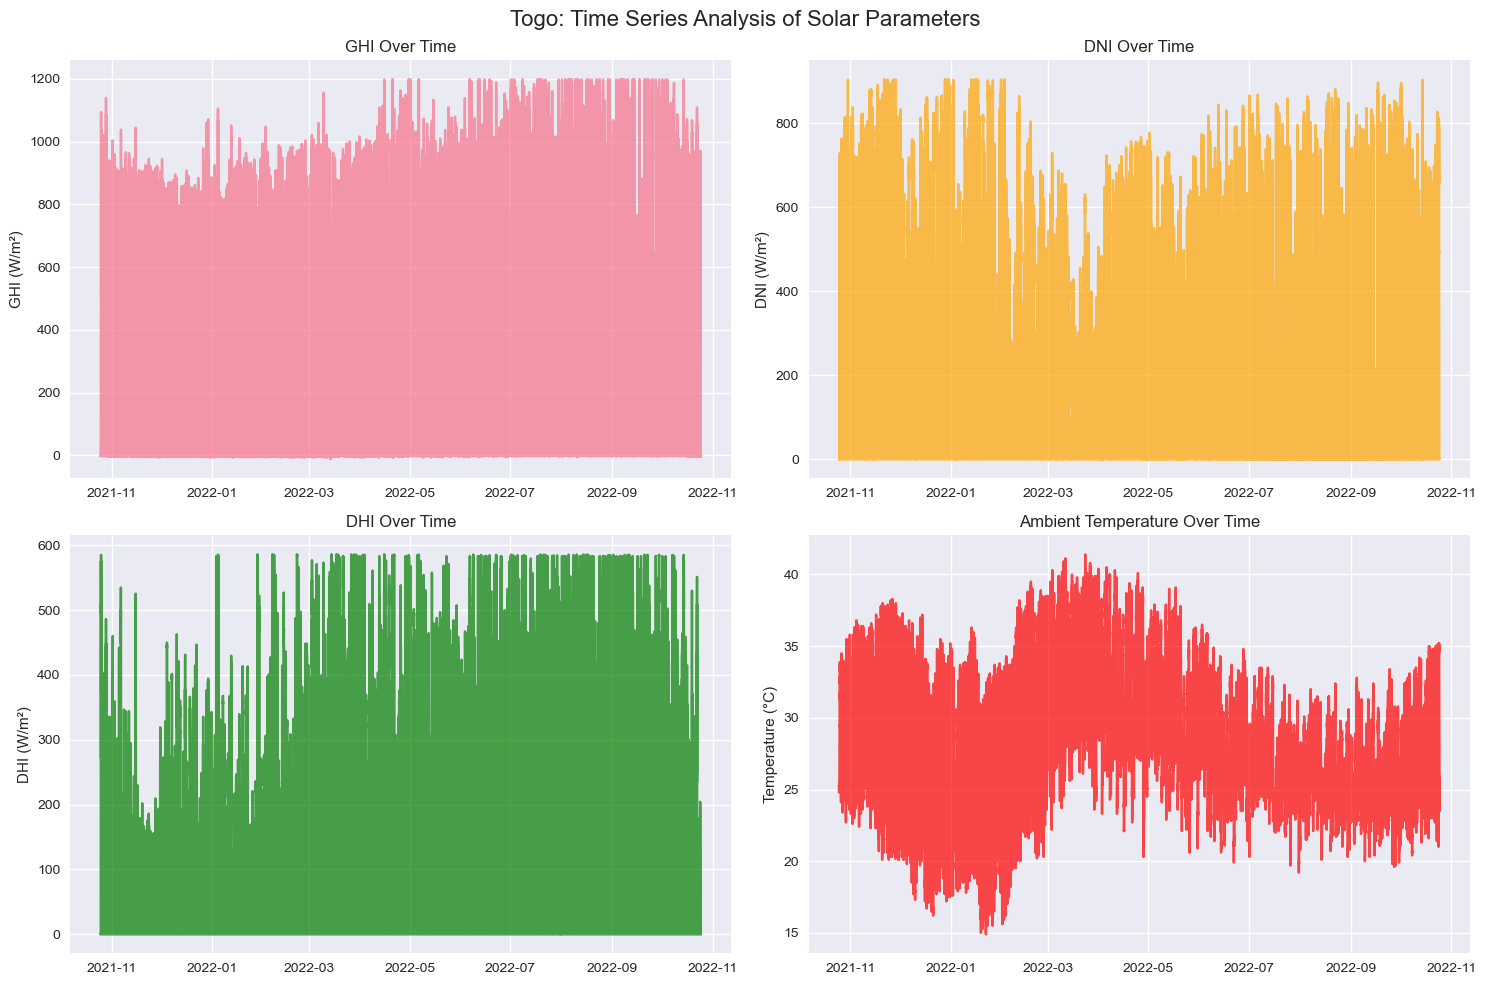

In [8]:
# Cell 5: Time Series Analysis
print("=== 4. TIME SERIES ANALYSIS ===")

# Set timestamp as index
togo_clean.set_index('Timestamp', inplace=True)

# Create time-based features
togo_clean['hour'] = togo_clean.index.hour
togo_clean['month'] = togo_clean.index.month

# Plot time series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Togo: Time Series Analysis of Solar Parameters', fontsize=16)

axes[0,0].plot(togo_clean.index, togo_clean['GHI'], alpha=0.7)
axes[0,0].set_title('GHI Over Time')
axes[0,0].set_ylabel('GHI (W/m²)')

axes[0,1].plot(togo_clean.index, togo_clean['DNI'], alpha=0.7, color='orange')
axes[0,1].set_title('DNI Over Time')
axes[0,1].set_ylabel('DNI (W/m²)')

axes[1,0].plot(togo_clean.index, togo_clean['DHI'], alpha=0.7, color='green')
axes[1,0].set_title('DHI Over Time')
axes[1,0].set_ylabel('DHI (W/m²)')

axes[1,1].plot(togo_clean.index, togo_clean['Tamb'], alpha=0.7, color='red')
axes[1,1].set_title('Ambient Temperature Over Time')
axes[1,1].set_ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

=== 5. CORRELATION ANALYSIS ===


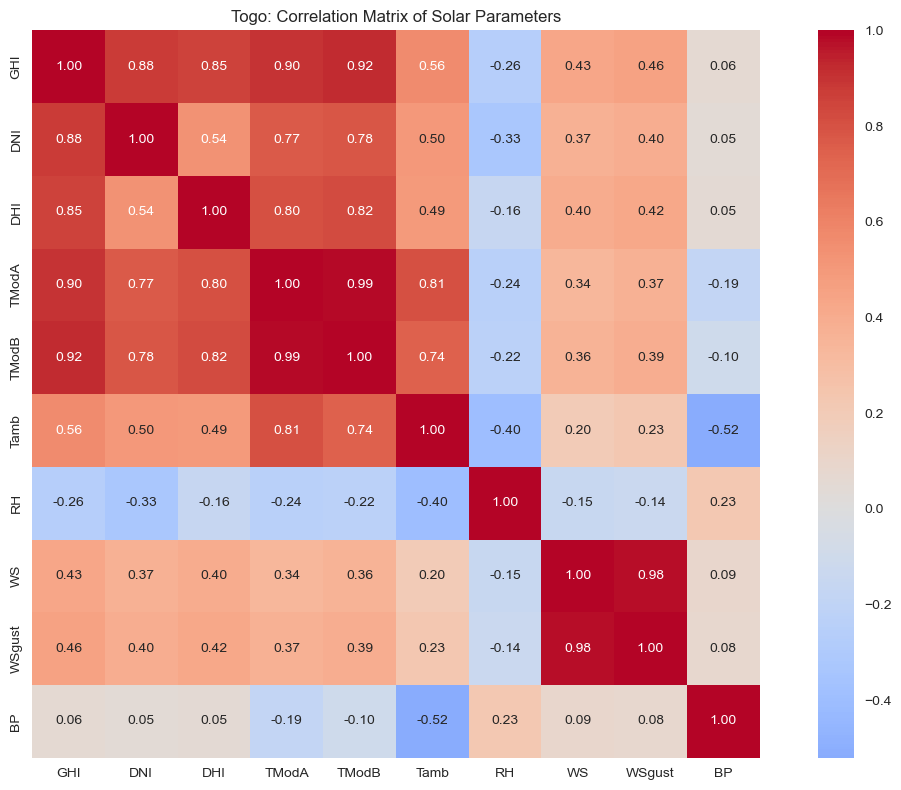

In [9]:
# Cell 6: Correlation Analysis
print("=== 5. CORRELATION ANALYSIS ===")

correlation_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB', 'Tamb', 'RH', 'WS', 'WSgust', 'BP']
correlation_cols = [col for col in correlation_cols if col in togo_clean.columns]

plt.figure(figsize=(12, 8))
corr_matrix = togo_clean[correlation_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Togo: Correlation Matrix of Solar Parameters')
plt.tight_layout()
plt.show()

=== 6. DISTRIBUTION ANALYSIS ===


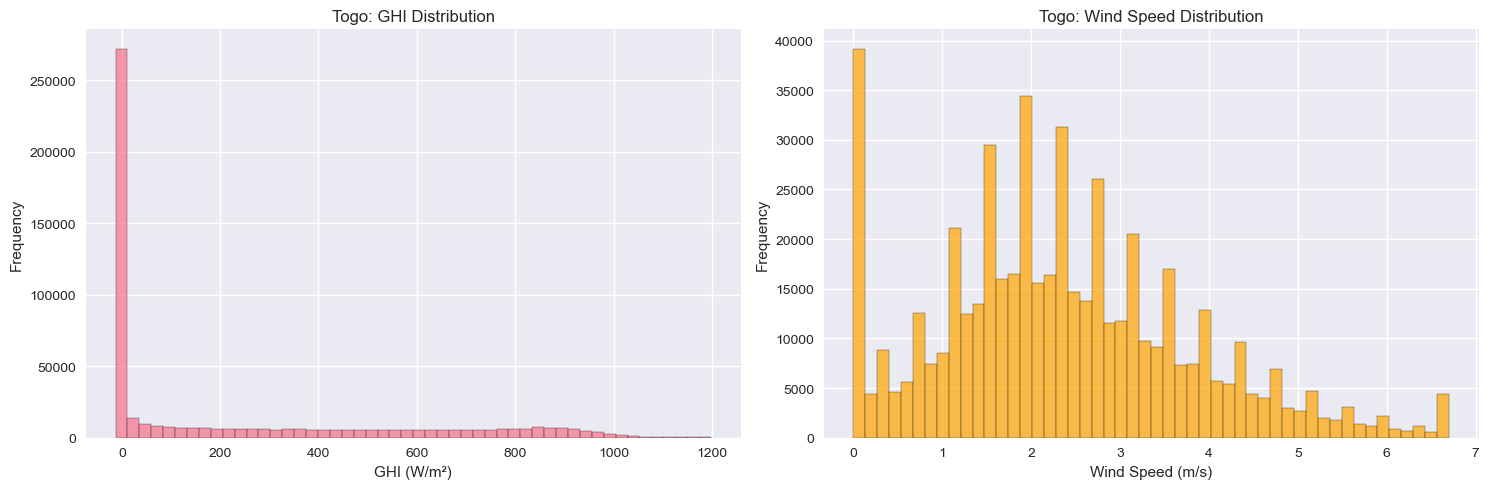

In [10]:
# Cell 7: Distribution Analysis
print("=== 6. DISTRIBUTION ANALYSIS ===")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(togo_clean['GHI'].dropna(), bins=50, alpha=0.7, edgecolor='black')
axes[0].set_xlabel('GHI (W/m²)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Togo: GHI Distribution')

if 'WS' in togo_clean.columns:
    axes[1].hist(togo_clean['WS'].dropna(), bins=50, alpha=0.7, color='orange', edgecolor='black')
    axes[1].set_xlabel('Wind Speed (m/s)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Togo: Wind Speed Distribution')

plt.tight_layout()
plt.show()

In [12]:
# Cell 8: Export Cleaned Data
print("=== 7. EXPORTING CLEANED DATA ===")

togo_clean_reset = togo_clean.reset_index()
output_path = '../data/togo_clean.csv'
togo_clean_reset.to_csv(output_path, index=False)
print(f"Togo cleaned data exported to: {output_path}")

=== 7. EXPORTING CLEANED DATA ===
Togo cleaned data exported to: ../data/togo_clean.csv


In [14]:
# Cell 9: Key Insights Summary
print("=== 8. TOGO KEY INSIGHTS SUMMARY ===")

print(f"\nData Quality:")
print(f"  - Missing values: {togo_df.isnull().sum().sum()}")
print(f"  - Columns with >5% missing: {high_missing_cols}")

print(f"\nSolar Radiation:")
print(f"  - Average GHI: {togo_clean['GHI'].mean():.2f} W/m²")
print(f"  - Average DNI: {togo_clean['DNI'].mean():.2f} W/m²")

print(f"\nTemperature:")
print(f"  - Average: {togo_clean['Tamb'].mean():.2f} °C")
print(f"  - Range: {togo_clean['Tamb'].min():.2f} - {togo_clean['Tamb'].max():.2f} °C")

print("\nTogo EDA completed successfully!")

=== 8. TOGO KEY INSIGHTS SUMMARY ===

Data Quality:
  - Missing values: 525600
  - Columns with >5% missing: ['Comments']

Solar Radiation:
  - Average GHI: 230.53 W/m²
  - Average DNI: 151.19 W/m²

Temperature:
  - Average: 27.75 °C
  - Range: 14.90 - 41.40 °C

Togo EDA completed successfully!
